In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pil
import skimage as im
import astropy.io.fits as fits
from skimage.filters import threshold_otsu
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.colors as colors

%matplotlib inline
#%matplotlib widget

In [2]:
def loadStack(mask, first, last) :
    img = np.array([1.0])
    for idx in np.arange(first,last+1) :
        fname=mask.format(idx)
        hdul = fits.open(fname)
        tmp = hdul[0].data.astype(float)
        
        if (idx==first):
            img.resize(tmp.shape[0],tmp.shape[1],last-first+1)
            
        img[:,:,idx-first]=tmp
        
    return img

In [3]:
dc=loadStack('/data/P20180255/02_rawdata/00_XCalibration/dc_{:05}.fits',1,10).astype(float).mean(axis=2);
ob=loadStack('/data/P20180255/02_rawdata/00_XCalibration/ob_{:05}.fits',1,10).astype(float).mean(axis=2);


In [4]:
ob1=ob-dc
np.nan_to_num(ob1)
ob1[ob1<0]=0


In [22]:
a=np.arange(0,10)
a[a<3]=3
a

array([3, 3, 3, 3, 4, 5, 6, 7, 8, 9])

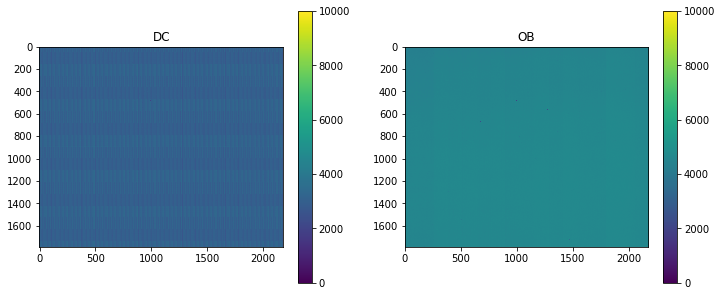

In [13]:
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(dc,vmax=10000,vmin=0)
plt.title('DC')
plt.colorbar()
plt.subplot(1,2,2)
ob2=ob1[450:500,975:1050]
plt.imshow(ob1,vmax=10000,vmin=0)
plt.title('OB')
plt.colorbar()

In [49]:
cal=loadStack('/data/P20180255/02_rawdata/00_XCalibration/xcal_{:05}.fits',1,10).astype(float)

In [50]:
for idx in np.arange(0, cal.shape[2]):
    cal[:,:,idx]=((cal[:,:,idx]-dc)/ob)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [52]:
lcal[lcal<=0]=1
lcal=-np.log(lcal)
lcal=np.nan_to_num(lcal)

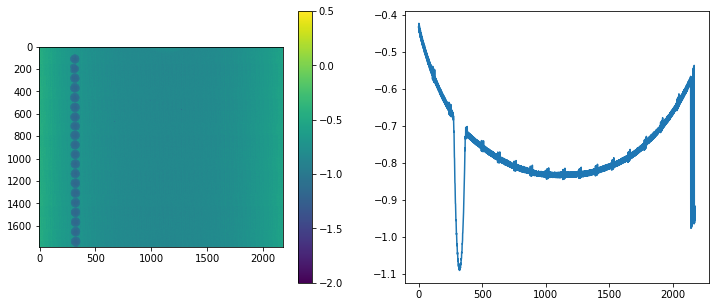

In [55]:
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
#plt.imshow(lcal[:,:,1])
plt.imshow(lcal[:,:,1],vmin=-2,vmax=0.5)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(lcal[:,:,1].mean(axis=0))


In [84]:
mcal=np.median(cal[1:N:10],axis=0)

In [85]:
d0=np.mean(cal[0,10:20,10:20])
for i in np.arange(1,N) :
    di=np.mean(cal[i,10:20,10:20]) 
    cal[i]=d0/di*cal[i]

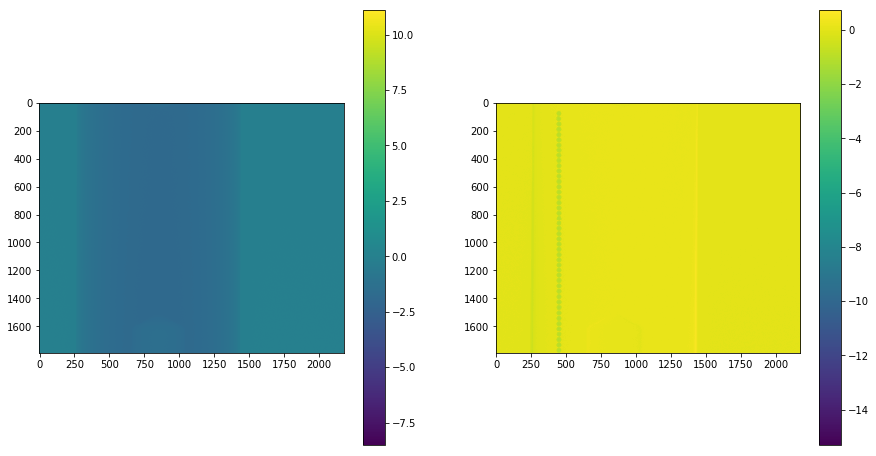

In [248]:
plt.figure(figsize=[15,8])
plt.subplot(1,2,1)
plt.imshow(mcal)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(cal[1].reshape(mcal.shape)-mcal)
plt.colorbar()

In [42]:
def minmax(img) :
    print(img.min(),img.max(), img.mean(), img.std())

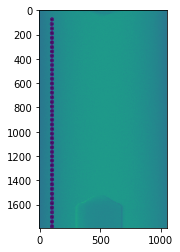

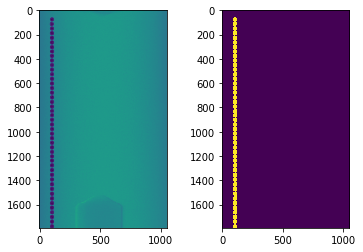

In [237]:
a=cal[4].reshape(mcal.shape)-mcal
a=a[:,350:1400]
plt.subplot(1,2,1)
plt.imshow(a)
th=threshold_otsu(a)
b=a<th
plt.subplot(1,2,2)
plt.imshow(a<th)

In [238]:
distance = ndi.distance_transform_edt(b)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((9,9)),labels=b)
markers = ndi.label(local_maxi)[0]

labels = watershed(-distance, markers, mask=b)

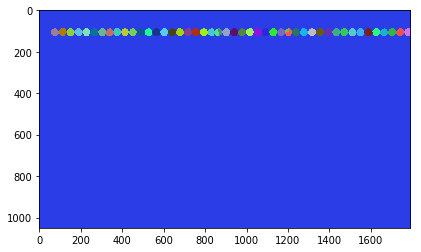

In [239]:
cmap = colors.ListedColormap ( np.random.rand ( 256,3))
plt.figure(figsize=[15,4])
plt.imshow(np.transpose(labels),cmap=cmap)

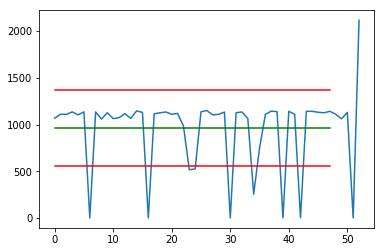

In [240]:
h,ax=np.histogram(labels,bins=np.arange(0,labels.max()+1))
plt.plot(h[1:])
plt.plot([0,47],[h[1:].mean(), h[1:].mean()],'g')
plt.plot([0,47],[h[1:].mean()-h[1:].std(), h[1:].mean()-h[1:].std()],'r')
plt.plot([0,47],[h[1:].mean()+h[1:].std(), h[1:].mean()+h[1:].std()],'r')

In [245]:
m=h[np.argwhere(h<0.1*np.prod(labels.shape))].mean()
s=h[1:].std()
print(m,s,m-s,m+s)


960.264150943 407.537712154 552.726438789 1367.8018631


In [242]:
def findBeads(img) :
    distance = ndi.distance_transform_edt(img)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((9,9)),labels=b)
    markers = ndi.label(local_maxi)[0]

    labels = watershed(-distance, markers, mask=b)
    h,ax=np.histogram(labels,bins=np.arange(0,labels.max()+1))
    m=h[np.argwhere(h<0.05*np.prod(labels.shape))].mean()
    s=h[np.argwhere(h<0.05*np.prod(labels.shape))].std()
    cog=[]
    for i in np.arange(0, h.size) :
        if ((m-s)<h[i]) and (h[i]<(m+s)) :
            selection=np.argwhere(labels==i)
            cog.append(selection.mean(axis=0))
       
    cog=np.asarray(cog)
    return cog


[[   76.22003745   106.20131086]
 [  113.59189189   104.70720721]
 [  151.4566787    106.2698556 ]
 [  189.9339207    105.96740088]
 [  228.23028105   106.01450589]
 [  266.30748899   106.36475771]
 [  304.74338624   106.30687831]
 [  340.41965974   107.35160681]
 [  376.46269982   105.88809947]
 [  413.97742239   106.13076199]
 [  451.64958062   106.61509786]
 [  489.36794987   106.57296329]
 [  527.07223265   106.53283302]
 [  564.95196507   106.64017467]
 [  603.43716814   106.54690265]
 [  641.30672646   106.72017937]
 [  678.93244444   106.456     ]
 [  717.21693122   106.76895944]
 [  755.24346258   106.77908025]
 [  793.30920465   106.66577301]
 [  829.35736041   107.01319797]
 [  901.69366197   106.72623239]
 [  940.13217391   106.6       ]
 [  977.95644283   106.97277677]
 [ 1015.33453562   106.68349865]
 [ 1052.58781995   106.51368049]
 [ 1090.73623446   106.92184725]
 [ 1128.60758377   106.58818342]
 [ 1165.96616541   106.69548872]
 [ 1204.21715818   109.41689008]
 [ 1237.11

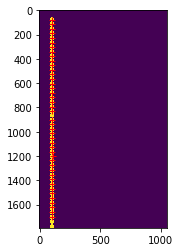

In [250]:
cog=findBeads(b)
print(cog) 
plt.figure(figsize=[15,4])
plt.imshow(b)

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')

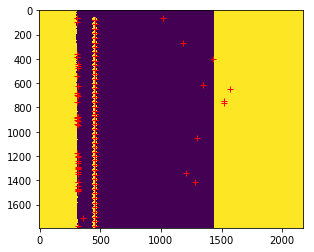

In [161]:
labels.shape

(1792, 250)

In [144]:
pos.mean(axis=0)

array([ 113.5       ,  154.69606004])